In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import shutil
import plotly.graph_objects as go

In [16]:
main_folder = "/workspaces/Futures-First/Prediction/data"
files = []
def list_folders(folder_path):
    # List only subdirectories (folders) in the given folder path
    return [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

def select_folder(folder_list, folder_path):
    # Show subfolders to select from
    print("\nSubfolders:")
    for i, folder in enumerate(folder_list, 1):
        print(f"{i}. {folder}")
    
    # Get the user's choice
    choice = int(input("\nSelect the number of the folder: ")) - 1
    return os.path.join(folder_path, folder_list[choice])

# List folders in the main folder and select one
subfolders = list_folders(main_folder)
first_selected_folder = select_folder(subfolders, main_folder)

# List folders in the first selected folder and select one
subfolders_in_first = list_folders(first_selected_folder)
second_selected_folder = select_folder(subfolders_in_first, first_selected_folder)

# Print all files in the second selected folder
# print(f"\nFiles in '{second_selected_folder}':")
for file_name in os.listdir(second_selected_folder):
    if os.path.isfile(os.path.join(second_selected_folder, file_name)):
        # print(file_name)
        files.append(second_selected_folder +'/' +file_name)
files.sort()
files        



Subfolders:
1. SoyOil
2. SoyBean
3. Wheat
4. Gold
5. Milling Wheat
6. SoyMeal
7. Live Cattle
8. Copper
9. Corn

Subfolders:
1. ZW Dec
2. ZW Dec-Mar


['/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2015.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2016.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2017.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2018.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2019.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2020.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2021.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2022.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2023.csv',
 '/workspaces/Futures-First/Prediction/data/Wheat/ZW Dec-Mar/2024.csv']

In [17]:
def delete_contents(folder_path):
    # List all items (files and folders) in the directory
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # If it's a file, remove it
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        
        # If it's a folder, remove it and its contents
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            # print(f"Deleted folder: {item_path}")

# Provide the path to the folder you want to clean
folder_to_clean = '/workspaces/Futures-First/Prediction/LSTM/test'
delete_contents(folder_to_clean)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# LSTM Model with Dropout and increased complexity
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_rate=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Only the last output is used for regression
        return out

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Train function with Early Stopping
def train_one_epoch(train_loader, model, optimizer, loss_function, epoch):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

def validate_one_epoch(test_loader, model, loss_function):
    model.eval()
    running_loss = 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    return avg_loss_across_batches

# Data preparation
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)
    df.dropna(inplace=True)
    return df

cpu


LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.203
***************************************************
Epoch: 2

Val Loss: 0.207
***************************************************
Epoch: 3

Val Loss: 0.187
***************************************************
Epoch: 4

Val Loss: 0.209
***************************************************
Epoch: 5

Val Loss: 0.193
***************************************************
Epoch: 6

Val Loss: 0.185
***************************************************
Epoch: 7

Val Loss: 0.202
***************************************************
Epoch: 8

Val Loss: 0.206
***************************************************
Epoch: 9

Val Loss: 0.189
***************************************************
Epoch: 10

Val Loss: 0.190
***************************************************
Epoch: 11

Val Loss: 0.176
***************************************************
Epoch: 

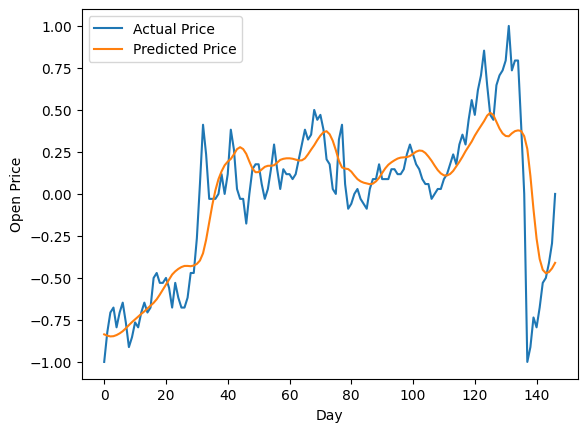

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.237
***************************************************
Epoch: 2

Val Loss: 0.234
***************************************************
Epoch: 3

Val Loss: 0.235
***************************************************
Epoch: 4

Val Loss: 0.225
***************************************************
Epoch: 5

Val Loss: 0.231
***************************************************
Epoch: 6

Val Loss: 0.217
***************************************************
Epoch: 7

Val Loss: 0.208
***************************************************
Epoch: 8

Val Loss: 0.177
***************************************************
Epoch: 9

Val Loss: 0.122
***************************************************
Epoch: 10

Val Loss: 0.071
***************************************************
Epoch: 11

Val Loss: 0.063
***************************************************
Epoch: 

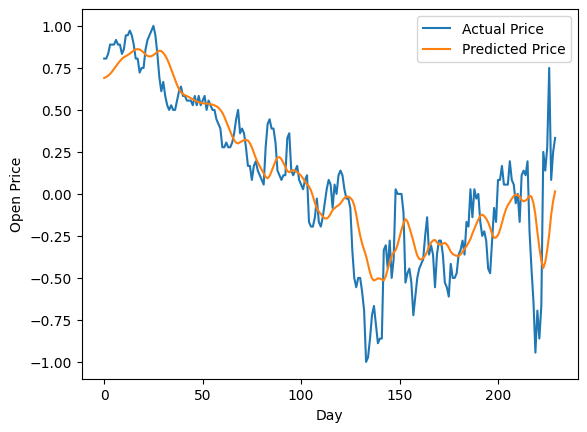

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.196
***************************************************
Epoch: 2

Val Loss: 0.199
***************************************************
Epoch: 3

Val Loss: 0.181
***************************************************
Epoch: 4

Val Loss: 0.172
***************************************************
Epoch: 5

Val Loss: 0.166
***************************************************
Epoch: 6

Val Loss: 0.155
***************************************************
Epoch: 7

Val Loss: 0.152
***************************************************
Epoch: 8

Val Loss: 0.127
***************************************************
Epoch: 9

Val Loss: 0.093
***************************************************
Epoch: 10

Val Loss: 0.065
***************************************************
Epoch: 11

Val Loss: 0.055
***************************************************
Epoch: 

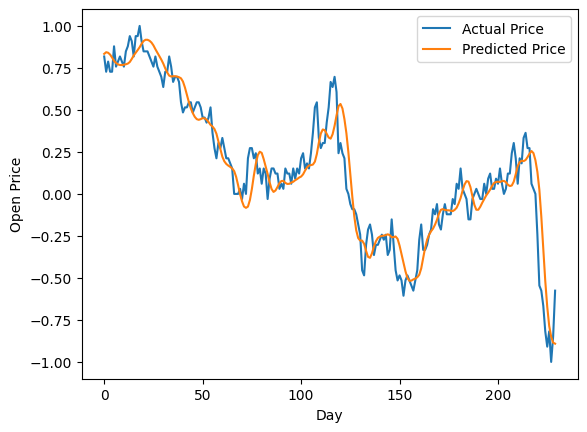

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.314
***************************************************
Epoch: 2

Val Loss: 0.281
***************************************************
Epoch: 3

Val Loss: 0.241
***************************************************
Epoch: 4

Val Loss: 0.180
***************************************************
Epoch: 5

Val Loss: 0.123
***************************************************
Epoch: 6

Val Loss: 0.097
***************************************************
Epoch: 7

Val Loss: 0.095
***************************************************
Epoch: 8

Val Loss: 0.091
***************************************************
Epoch: 9

Val Loss: 0.086
***************************************************
Epoch: 10

Val Loss: 0.085
***************************************************
Epoch: 11

Val Loss: 0.078
***************************************************
Epoch: 

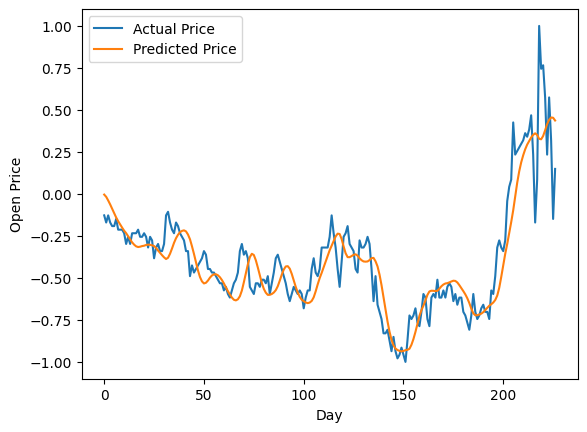

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.190
***************************************************
Epoch: 2

Val Loss: 0.162
***************************************************
Epoch: 3

Val Loss: 0.144
***************************************************
Epoch: 4

Val Loss: 0.134
***************************************************
Epoch: 5

Val Loss: 0.120
***************************************************
Epoch: 6

Val Loss: 0.108
***************************************************
Epoch: 7

Val Loss: 0.102
***************************************************
Epoch: 8

Val Loss: 0.103
***************************************************
Epoch: 9

Val Loss: 0.084
***************************************************
Epoch: 10

Val Loss: 0.072
***************************************************
Epoch: 11

Val Loss: 0.059
***************************************************
Epoch: 

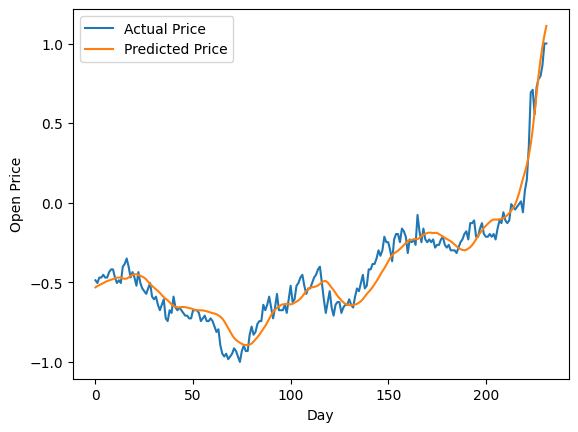

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.171
***************************************************
Epoch: 2

Val Loss: 0.152
***************************************************
Epoch: 3

Val Loss: 0.132
***************************************************
Epoch: 4

Val Loss: 0.116
***************************************************
Epoch: 5

Val Loss: 0.104
***************************************************
Epoch: 6

Val Loss: 0.096
***************************************************
Epoch: 7

Val Loss: 0.099
***************************************************
Epoch: 8

Val Loss: 0.099
***************************************************
Epoch: 9

Val Loss: 0.093
***************************************************
Epoch: 10

Val Loss: 0.093
***************************************************
Epoch: 11

Val Loss: 0.092
***************************************************
Epoch: 

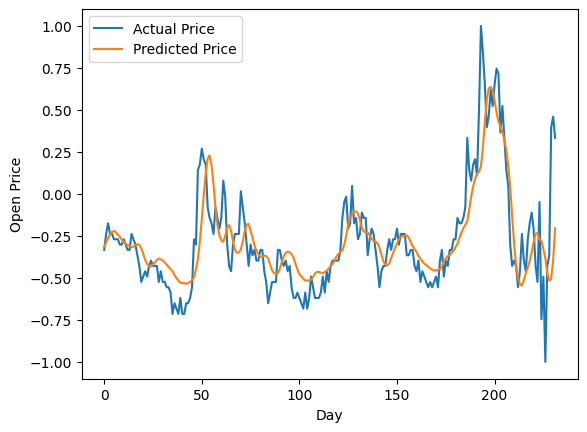

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.215
***************************************************
Epoch: 2

Val Loss: 0.205
***************************************************
Epoch: 3

Val Loss: 0.208
***************************************************
Epoch: 4

Val Loss: 0.202
***************************************************
Epoch: 5

Val Loss: 0.203
***************************************************
Epoch: 6

Val Loss: 0.200
***************************************************
Epoch: 7

Val Loss: 0.176
***************************************************
Epoch: 8

Val Loss: 0.149
***************************************************
Epoch: 9

Val Loss: 0.090
***************************************************
Epoch: 10

Val Loss: 0.071
***************************************************
Epoch: 11

Val Loss: 0.066
***************************************************
Epoch: 

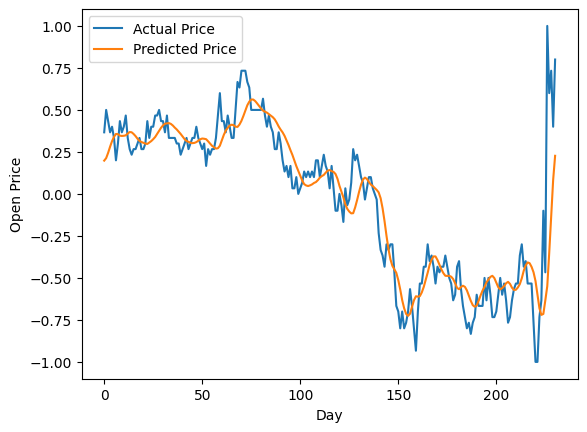

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.282
***************************************************
Epoch: 2

Val Loss: 0.248
***************************************************
Epoch: 3

Val Loss: 0.223
***************************************************
Epoch: 4

Val Loss: 0.177
***************************************************
Epoch: 5

Val Loss: 0.152
***************************************************
Epoch: 6

Val Loss: 0.133
***************************************************
Epoch: 7

Val Loss: 0.127
***************************************************
Epoch: 8

Val Loss: 0.121
***************************************************
Epoch: 9

Val Loss: 0.123
***************************************************
Epoch: 10

Val Loss: 0.104
***************************************************
Epoch: 11

Val Loss: 0.091
***************************************************
Epoch: 

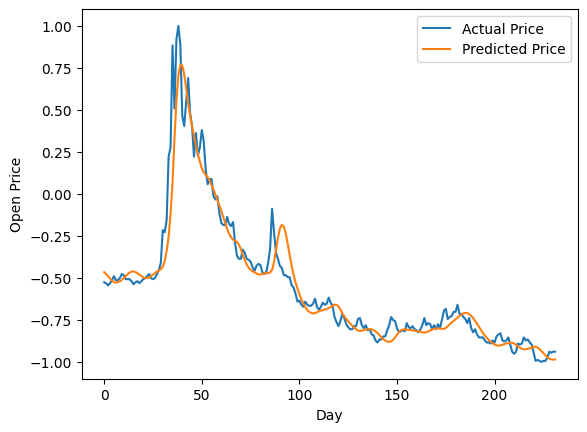

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.389
***************************************************
Epoch: 2

Val Loss: 0.382
***************************************************
Epoch: 3

Val Loss: 0.372
***************************************************
Epoch: 4

Val Loss: 0.362
***************************************************
Epoch: 5

Val Loss: 0.354
***************************************************
Epoch: 6

Val Loss: 0.339
***************************************************
Epoch: 7

Val Loss: 0.293
***************************************************
Epoch: 8

Val Loss: 0.222
***************************************************
Epoch: 9

Val Loss: 0.125
***************************************************
Epoch: 10

Val Loss: 0.060
***************************************************
Epoch: 11

Val Loss: 0.044
***************************************************
Epoch: 

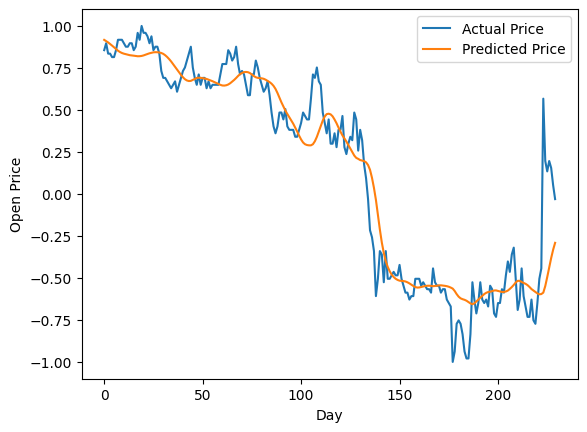

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.257
***************************************************
Epoch: 2

Val Loss: 0.271
***************************************************
Epoch: 3

Val Loss: 0.229
***************************************************
Epoch: 4

Val Loss: 0.233
***************************************************
Epoch: 5

Val Loss: 0.239
***************************************************
Epoch: 6

Val Loss: 0.213
***************************************************
Epoch: 7

Val Loss: 0.205
***************************************************
Epoch: 8

Val Loss: 0.218
***************************************************
Epoch: 9

Val Loss: 0.198
***************************************************
Epoch: 10

Val Loss: 0.224
***************************************************
Epoch: 11

Val Loss: 0.202
***************************************************
Epoch: 

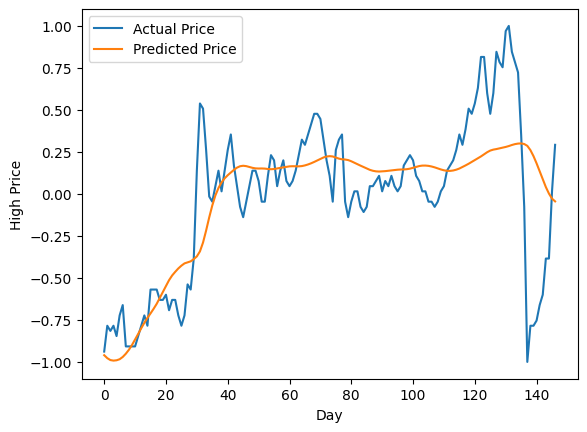

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.208
***************************************************
Epoch: 2

Val Loss: 0.201
***************************************************
Epoch: 3

Val Loss: 0.208
***************************************************
Epoch: 4

Val Loss: 0.199
***************************************************
Epoch: 5

Val Loss: 0.201
***************************************************
Epoch: 6

Val Loss: 0.194
***************************************************
Epoch: 7

Val Loss: 0.179
***************************************************
Epoch: 8

Val Loss: 0.154
***************************************************
Epoch: 9

Val Loss: 0.111
***************************************************
Epoch: 10

Val Loss: 0.062
***************************************************
Epoch: 11

Val Loss: 0.059
***************************************************
Epoch: 

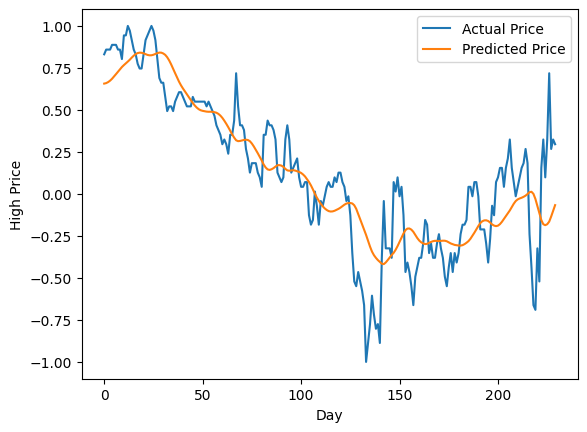

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.185
***************************************************
Epoch: 2

Val Loss: 0.180
***************************************************
Epoch: 3

Val Loss: 0.178
***************************************************
Epoch: 4

Val Loss: 0.175
***************************************************
Epoch: 5

Val Loss: 0.171
***************************************************
Epoch: 6

Val Loss: 0.166
***************************************************
Epoch: 7

Val Loss: 0.153
***************************************************
Epoch: 8

Val Loss: 0.136
***************************************************
Epoch: 9

Val Loss: 0.111
***************************************************
Epoch: 10

Val Loss: 0.067
***************************************************
Epoch: 11

Val Loss: 0.062
***************************************************
Epoch: 

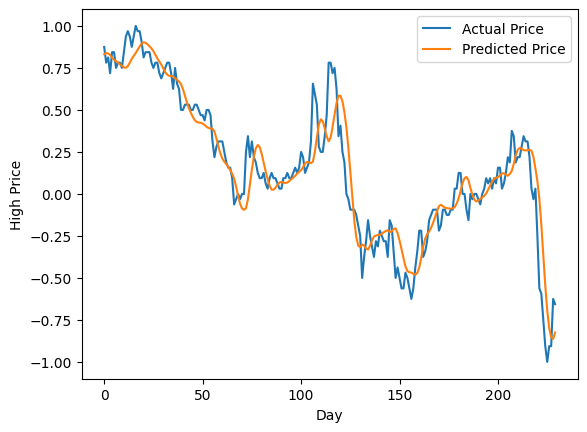

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.212
***************************************************
Epoch: 2

Val Loss: 0.182
***************************************************
Epoch: 3

Val Loss: 0.153
***************************************************
Epoch: 4

Val Loss: 0.124
***************************************************
Epoch: 5

Val Loss: 0.108
***************************************************
Epoch: 6

Val Loss: 0.100
***************************************************
Epoch: 7

Val Loss: 0.091
***************************************************
Epoch: 8

Val Loss: 0.087
***************************************************
Epoch: 9

Val Loss: 0.090
***************************************************
Epoch: 10

Val Loss: 0.085
***************************************************
Epoch: 11

Val Loss: 0.087
***************************************************
Epoch: 

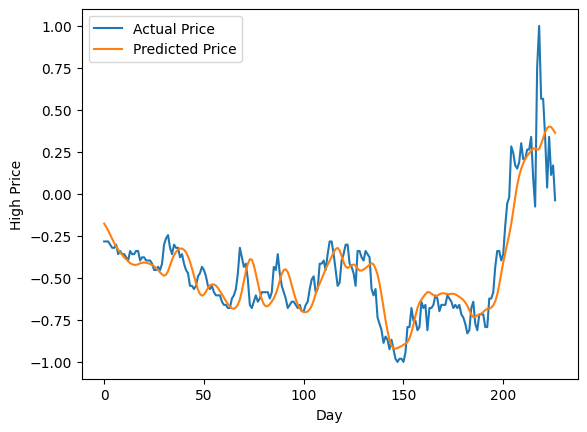

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.196
***************************************************
Epoch: 2

Val Loss: 0.178
***************************************************
Epoch: 3

Val Loss: 0.159
***************************************************
Epoch: 4

Val Loss: 0.139
***************************************************
Epoch: 5

Val Loss: 0.122
***************************************************
Epoch: 6

Val Loss: 0.116
***************************************************
Epoch: 7

Val Loss: 0.116
***************************************************
Epoch: 8

Val Loss: 0.109
***************************************************
Epoch: 9

Val Loss: 0.091
***************************************************
Epoch: 10

Val Loss: 0.079
***************************************************
Epoch: 11

Val Loss: 0.068
***************************************************
Epoch: 

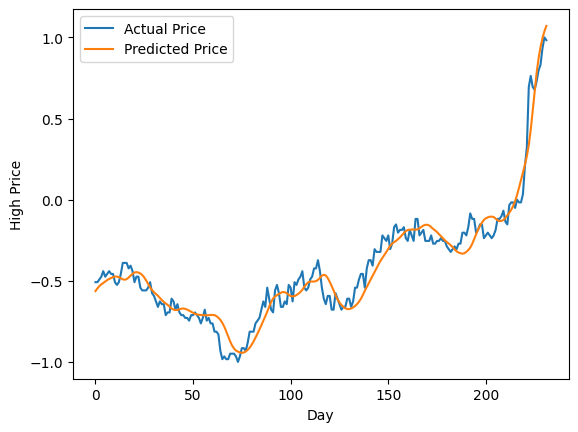

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.274
***************************************************
Epoch: 2

Val Loss: 0.242
***************************************************
Epoch: 3

Val Loss: 0.210
***************************************************
Epoch: 4

Val Loss: 0.182
***************************************************
Epoch: 5

Val Loss: 0.142
***************************************************
Epoch: 6

Val Loss: 0.122
***************************************************
Epoch: 7

Val Loss: 0.119
***************************************************
Epoch: 8

Val Loss: 0.115
***************************************************
Epoch: 9

Val Loss: 0.119
***************************************************
Epoch: 10

Val Loss: 0.111
***************************************************
Epoch: 11

Val Loss: 0.109
***************************************************
Epoch: 

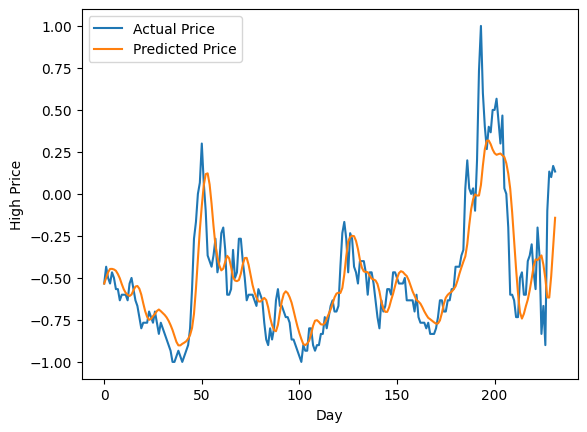

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.270
***************************************************
Epoch: 2

Val Loss: 0.268
***************************************************
Epoch: 3

Val Loss: 0.266
***************************************************
Epoch: 4

Val Loss: 0.255
***************************************************
Epoch: 5

Val Loss: 0.247
***************************************************
Epoch: 6

Val Loss: 0.239
***************************************************
Epoch: 7

Val Loss: 0.225
***************************************************
Epoch: 8

Val Loss: 0.185
***************************************************
Epoch: 9

Val Loss: 0.119
***************************************************
Epoch: 10

Val Loss: 0.090
***************************************************
Epoch: 11

Val Loss: 0.086
***************************************************
Epoch: 

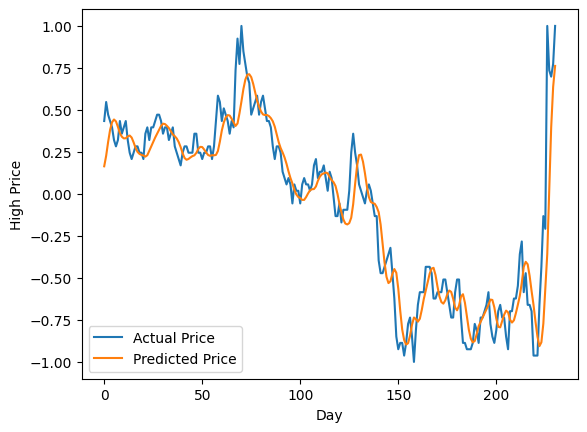

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.328
***************************************************
Epoch: 2

Val Loss: 0.291
***************************************************
Epoch: 3

Val Loss: 0.258
***************************************************
Epoch: 4

Val Loss: 0.216
***************************************************
Epoch: 5

Val Loss: 0.174
***************************************************
Epoch: 6

Val Loss: 0.132
***************************************************
Epoch: 7

Val Loss: 0.133
***************************************************
Epoch: 8

Val Loss: 0.121
***************************************************
Epoch: 9

Val Loss: 0.109
***************************************************
Epoch: 10

Val Loss: 0.098
***************************************************
Epoch: 11

Val Loss: 0.085
***************************************************
Epoch: 

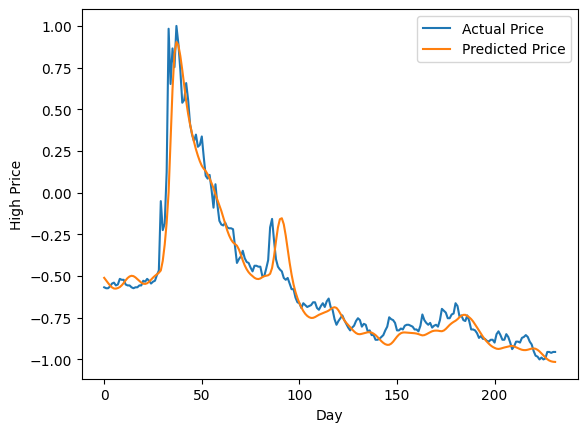

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.386
***************************************************
Epoch: 2

Val Loss: 0.380
***************************************************
Epoch: 3

Val Loss: 0.377
***************************************************
Epoch: 4

Val Loss: 0.368
***************************************************
Epoch: 5

Val Loss: 0.353
***************************************************
Epoch: 6

Val Loss: 0.333
***************************************************
Epoch: 7

Val Loss: 0.290
***************************************************
Epoch: 8

Val Loss: 0.217
***************************************************
Epoch: 9

Val Loss: 0.156
***************************************************
Epoch: 10

Val Loss: 0.106
***************************************************
Epoch: 11

Val Loss: 0.073
***************************************************
Epoch: 

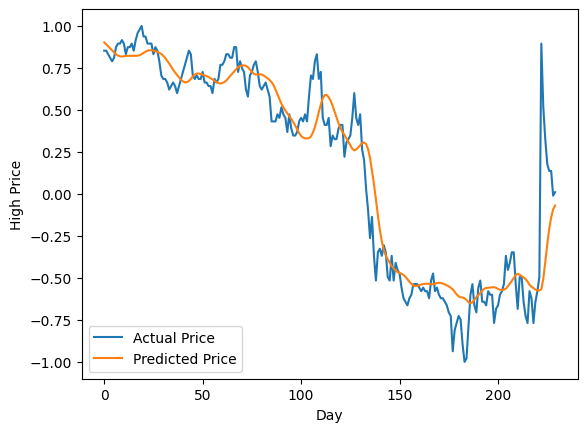

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.229
***************************************************
Epoch: 2

Val Loss: 0.228
***************************************************
Epoch: 3

Val Loss: 0.257
***************************************************
Epoch: 4

Val Loss: 0.213
***************************************************
Epoch: 5

Val Loss: 0.250
***************************************************
Epoch: 6

Val Loss: 0.219
***************************************************
Epoch: 7

Val Loss: 0.214
***************************************************
Epoch: 8

Val Loss: 0.189
***************************************************
Epoch: 9

Val Loss: 0.219
***************************************************
Epoch: 10

Val Loss: 0.199
***************************************************
Epoch: 11

Val Loss: 0.183
***************************************************
Epoch: 

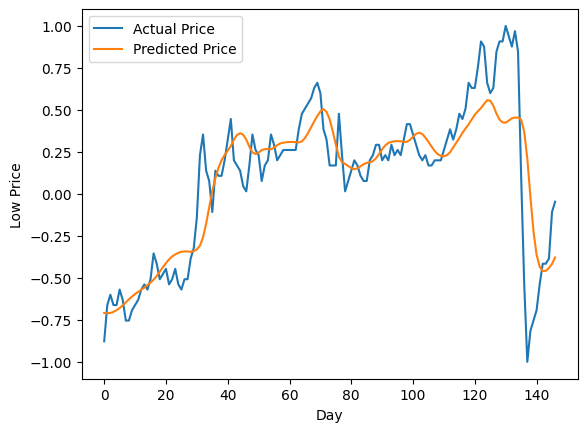

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.242
***************************************************
Epoch: 2

Val Loss: 0.248
***************************************************
Epoch: 3

Val Loss: 0.228
***************************************************
Epoch: 4

Val Loss: 0.223
***************************************************
Epoch: 5

Val Loss: 0.206
***************************************************
Epoch: 6

Val Loss: 0.188
***************************************************
Epoch: 7

Val Loss: 0.155
***************************************************
Epoch: 8

Val Loss: 0.096
***************************************************
Epoch: 9

Val Loss: 0.063
***************************************************
Epoch: 10

Val Loss: 0.055
***************************************************
Epoch: 11

Val Loss: 0.057
***************************************************
Epoch: 

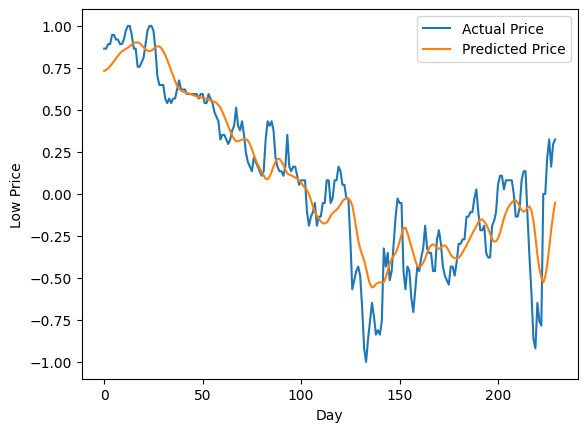

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.214
***************************************************
Epoch: 2

Val Loss: 0.201
***************************************************
Epoch: 3

Val Loss: 0.199
***************************************************
Epoch: 4

Val Loss: 0.190
***************************************************
Epoch: 5

Val Loss: 0.183
***************************************************
Epoch: 6

Val Loss: 0.185
***************************************************
Epoch: 7

Val Loss: 0.178
***************************************************
Epoch: 8

Val Loss: 0.153
***************************************************
Epoch: 9

Val Loss: 0.114
***************************************************
Epoch: 10

Val Loss: 0.076
***************************************************
Epoch: 11

Val Loss: 0.060
***************************************************
Epoch: 

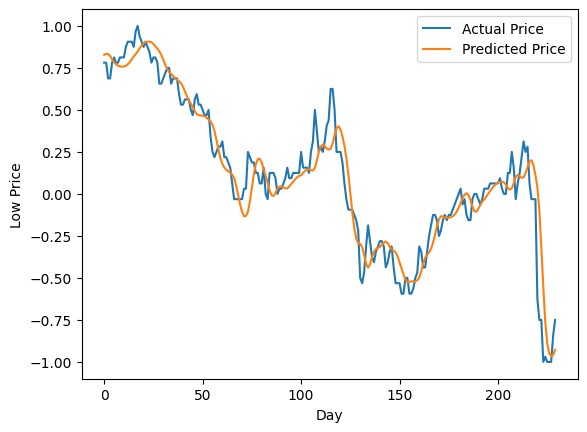

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.157
***************************************************
Epoch: 2

Val Loss: 0.145
***************************************************
Epoch: 3

Val Loss: 0.127
***************************************************
Epoch: 4

Val Loss: 0.119
***************************************************
Epoch: 5

Val Loss: 0.114
***************************************************
Epoch: 6

Val Loss: 0.101
***************************************************
Epoch: 7

Val Loss: 0.099
***************************************************
Epoch: 8

Val Loss: 0.101
***************************************************
Epoch: 9

Val Loss: 0.092
***************************************************
Epoch: 10

Val Loss: 0.087
***************************************************
Epoch: 11

Val Loss: 0.078
***************************************************
Epoch: 

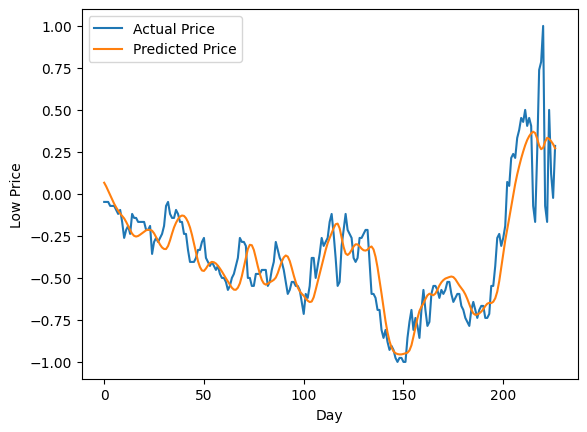

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.372
***************************************************
Epoch: 2

Val Loss: 0.332
***************************************************
Epoch: 3

Val Loss: 0.295
***************************************************
Epoch: 4

Val Loss: 0.247
***************************************************
Epoch: 5

Val Loss: 0.186
***************************************************
Epoch: 6

Val Loss: 0.124
***************************************************
Epoch: 7

Val Loss: 0.109
***************************************************
Epoch: 8

Val Loss: 0.102
***************************************************
Epoch: 9

Val Loss: 0.092
***************************************************
Epoch: 10

Val Loss: 0.083
***************************************************
Epoch: 11

Val Loss: 0.074
***************************************************
Epoch: 

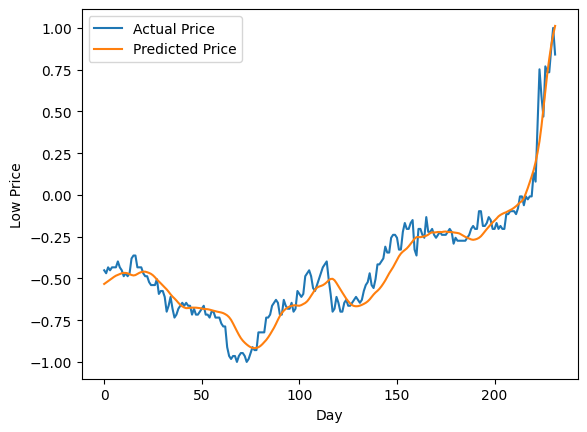

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.102
***************************************************
Epoch: 2

Val Loss: 0.099
***************************************************
Epoch: 3

Val Loss: 0.099
***************************************************
Epoch: 4

Val Loss: 0.097
***************************************************
Epoch: 5

Val Loss: 0.096
***************************************************
Epoch: 6

Val Loss: 0.097
***************************************************
Epoch: 7

Val Loss: 0.095
***************************************************
Epoch: 8

Val Loss: 0.093
***************************************************
Epoch: 9

Val Loss: 0.092
***************************************************
Epoch: 10

Val Loss: 0.091
***************************************************
Epoch: 11

Val Loss: 0.088
***************************************************
Epoch: 

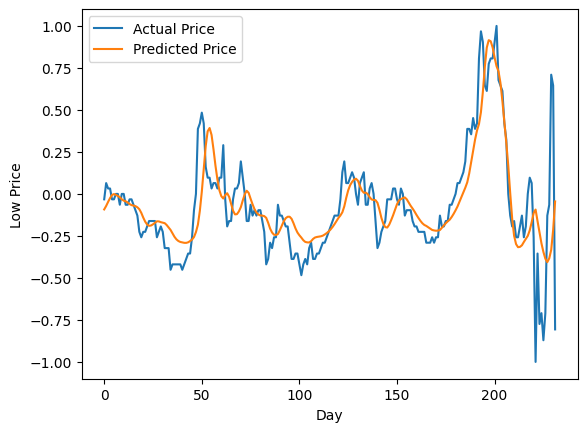

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.184
***************************************************
Epoch: 2

Val Loss: 0.186
***************************************************
Epoch: 3

Val Loss: 0.175
***************************************************
Epoch: 4

Val Loss: 0.173
***************************************************
Epoch: 5

Val Loss: 0.165
***************************************************
Epoch: 6

Val Loss: 0.158
***************************************************
Epoch: 7

Val Loss: 0.138
***************************************************
Epoch: 8

Val Loss: 0.112
***************************************************
Epoch: 9

Val Loss: 0.069
***************************************************
Epoch: 10

Val Loss: 0.054
***************************************************
Epoch: 11

Val Loss: 0.045
***************************************************
Epoch: 

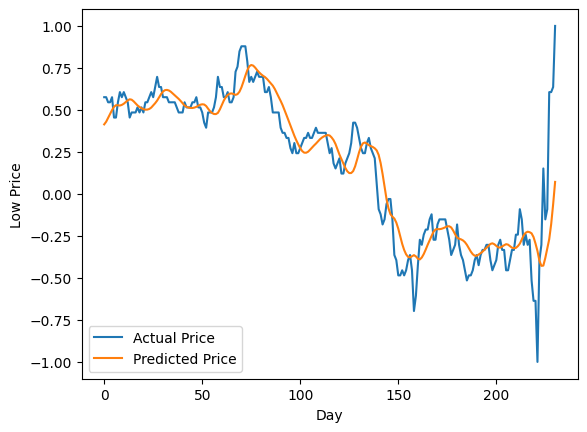

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.435
***************************************************
Epoch: 2

Val Loss: 0.393
***************************************************
Epoch: 3

Val Loss: 0.359
***************************************************
Epoch: 4

Val Loss: 0.310
***************************************************
Epoch: 5

Val Loss: 0.252
***************************************************
Epoch: 6

Val Loss: 0.168
***************************************************
Epoch: 7

Val Loss: 0.123
***************************************************
Epoch: 8

Val Loss: 0.113
***************************************************
Epoch: 9

Val Loss: 0.102
***************************************************
Epoch: 10

Val Loss: 0.088
***************************************************
Epoch: 11

Val Loss: 0.078
***************************************************
Epoch: 

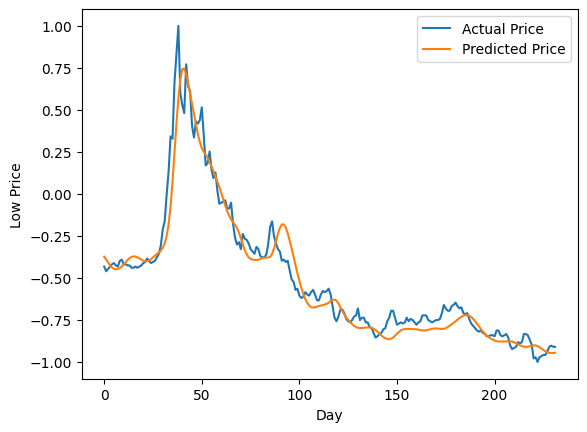

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.327
***************************************************
Epoch: 2

Val Loss: 0.326
***************************************************
Epoch: 3

Val Loss: 0.320
***************************************************
Epoch: 4

Val Loss: 0.304
***************************************************
Epoch: 5

Val Loss: 0.280
***************************************************
Epoch: 6

Val Loss: 0.247
***************************************************
Epoch: 7

Val Loss: 0.183
***************************************************
Epoch: 8

Val Loss: 0.111
***************************************************
Epoch: 9

Val Loss: 0.053
***************************************************
Epoch: 10

Val Loss: 0.035
***************************************************
Epoch: 11

Val Loss: 0.032
***************************************************
Epoch: 

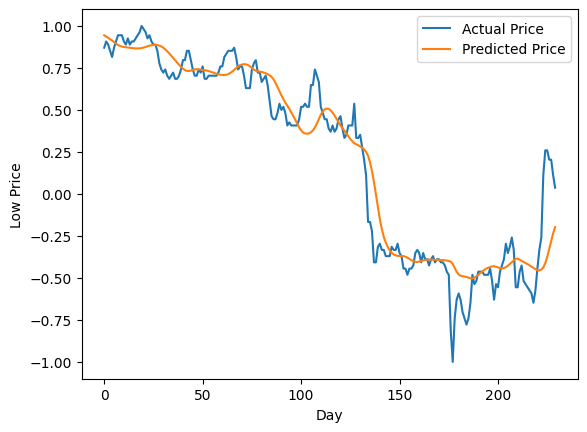

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.207
***************************************************
Epoch: 2

Val Loss: 0.224
***************************************************
Epoch: 3

Val Loss: 0.207
***************************************************
Epoch: 4

Val Loss: 0.221
***************************************************
Epoch: 5

Val Loss: 0.217
***************************************************
Epoch: 6

Val Loss: 0.198
***************************************************
Epoch: 7

Val Loss: 0.212
***************************************************
Epoch: 8

Val Loss: 0.219
***************************************************
Epoch: 9

Val Loss: 0.196
***************************************************
Epoch: 10

Val Loss: 0.210
***************************************************
Epoch: 11

Val Loss: 0.181
***************************************************
Epoch: 

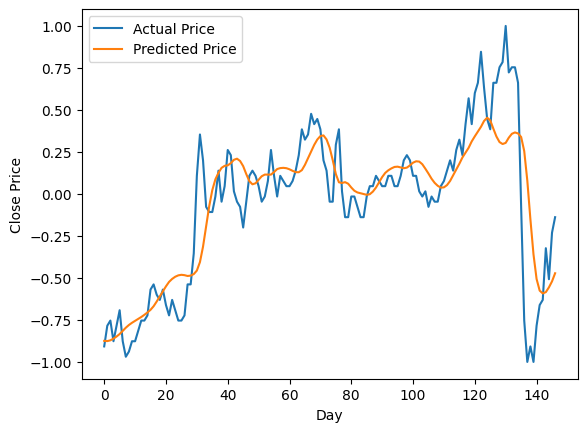

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.228
***************************************************
Epoch: 2

Val Loss: 0.235
***************************************************
Epoch: 3

Val Loss: 0.229
***************************************************
Epoch: 4

Val Loss: 0.225
***************************************************
Epoch: 5

Val Loss: 0.224
***************************************************
Epoch: 6

Val Loss: 0.219
***************************************************
Epoch: 7

Val Loss: 0.206
***************************************************
Epoch: 8

Val Loss: 0.191
***************************************************
Epoch: 9

Val Loss: 0.154
***************************************************
Epoch: 10

Val Loss: 0.091
***************************************************
Epoch: 11

Val Loss: 0.070
***************************************************
Epoch: 

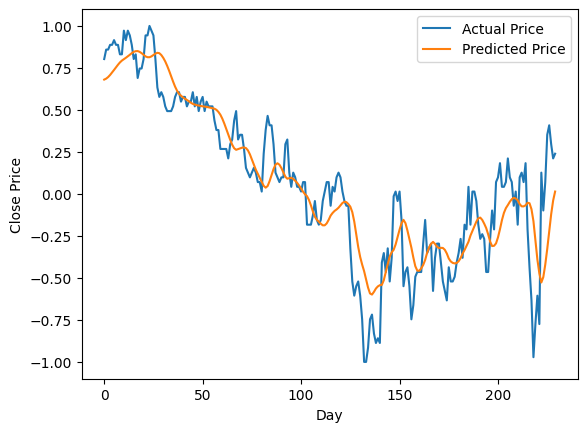

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.173
***************************************************
Epoch: 2

Val Loss: 0.192
***************************************************
Epoch: 3

Val Loss: 0.178
***************************************************
Epoch: 4

Val Loss: 0.168
***************************************************
Epoch: 5

Val Loss: 0.169
***************************************************
Epoch: 6

Val Loss: 0.178
***************************************************
Epoch: 7

Val Loss: 0.161
***************************************************
Epoch: 8

Val Loss: 0.157
***************************************************
Epoch: 9

Val Loss: 0.123
***************************************************
Epoch: 10

Val Loss: 0.091
***************************************************
Epoch: 11

Val Loss: 0.060
***************************************************
Epoch: 

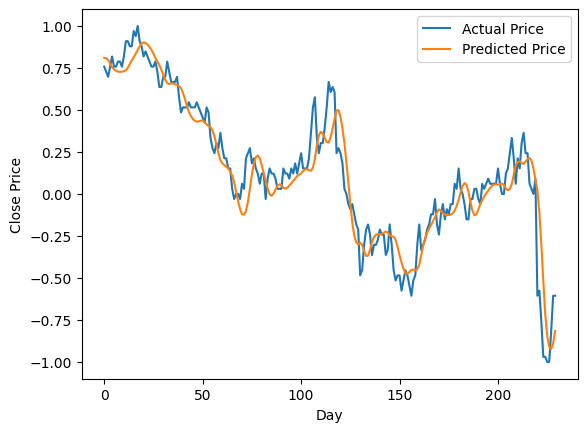

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.200
***************************************************
Epoch: 2

Val Loss: 0.173
***************************************************
Epoch: 3

Val Loss: 0.154
***************************************************
Epoch: 4

Val Loss: 0.138
***************************************************
Epoch: 5

Val Loss: 0.118
***************************************************
Epoch: 6

Val Loss: 0.110
***************************************************
Epoch: 7

Val Loss: 0.118
***************************************************
Epoch: 8

Val Loss: 0.112
***************************************************
Epoch: 9

Val Loss: 0.116
***************************************************
Epoch: 10

Val Loss: 0.101
***************************************************
Epoch: 11

Val Loss: 0.090
***************************************************
Epoch: 

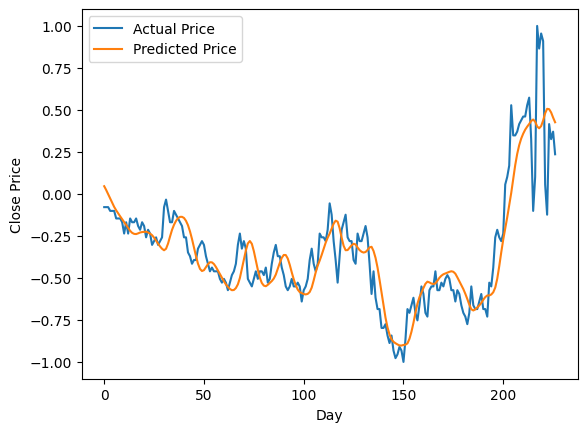

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.285
***************************************************
Epoch: 2

Val Loss: 0.253
***************************************************
Epoch: 3

Val Loss: 0.225
***************************************************
Epoch: 4

Val Loss: 0.189
***************************************************
Epoch: 5

Val Loss: 0.144
***************************************************
Epoch: 6

Val Loss: 0.104
***************************************************
Epoch: 7

Val Loss: 0.097
***************************************************
Epoch: 8

Val Loss: 0.090
***************************************************
Epoch: 9

Val Loss: 0.081
***************************************************
Epoch: 10

Val Loss: 0.070
***************************************************
Epoch: 11

Val Loss: 0.063
***************************************************
Epoch: 

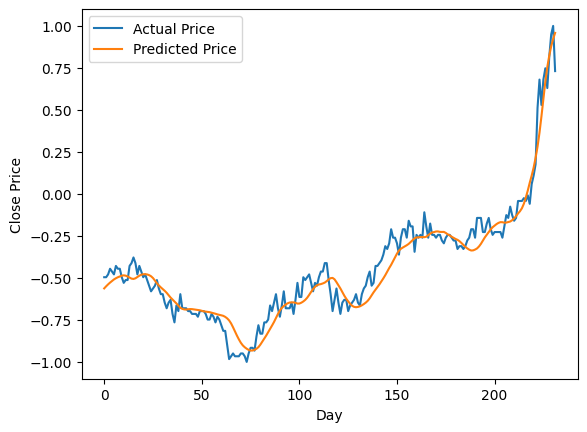

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.183
***************************************************
Epoch: 2

Val Loss: 0.156
***************************************************
Epoch: 3

Val Loss: 0.131
***************************************************
Epoch: 4

Val Loss: 0.108
***************************************************
Epoch: 5

Val Loss: 0.093
***************************************************
Epoch: 6

Val Loss: 0.096
***************************************************
Epoch: 7

Val Loss: 0.089
***************************************************
Epoch: 8

Val Loss: 0.088
***************************************************
Epoch: 9

Val Loss: 0.087
***************************************************
Epoch: 10

Val Loss: 0.099
***************************************************
Epoch: 11

Val Loss: 0.085
***************************************************
Epoch: 

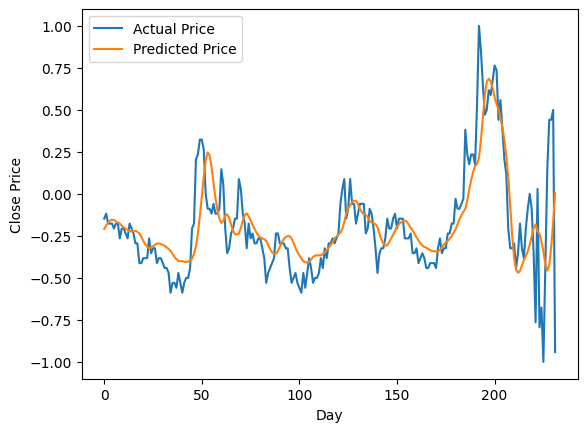

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.215
***************************************************
Epoch: 2

Val Loss: 0.203
***************************************************
Epoch: 3

Val Loss: 0.207
***************************************************
Epoch: 4

Val Loss: 0.196
***************************************************
Epoch: 5

Val Loss: 0.196
***************************************************
Epoch: 6

Val Loss: 0.191
***************************************************
Epoch: 7

Val Loss: 0.174
***************************************************
Epoch: 8

Val Loss: 0.150
***************************************************
Epoch: 9

Val Loss: 0.110
***************************************************
Epoch: 10

Val Loss: 0.068
***************************************************
Epoch: 11

Val Loss: 0.061
***************************************************
Epoch: 

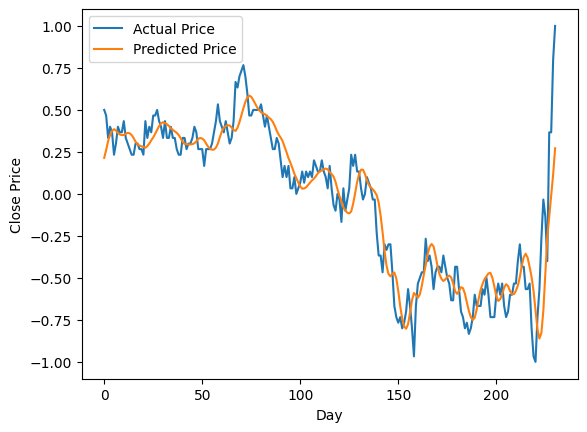

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.434
***************************************************
Epoch: 2

Val Loss: 0.387
***************************************************
Epoch: 3

Val Loss: 0.344
***************************************************
Epoch: 4

Val Loss: 0.286
***************************************************
Epoch: 5

Val Loss: 0.209
***************************************************
Epoch: 6

Val Loss: 0.131
***************************************************
Epoch: 7

Val Loss: 0.129
***************************************************
Epoch: 8

Val Loss: 0.124
***************************************************
Epoch: 9

Val Loss: 0.110
***************************************************
Epoch: 10

Val Loss: 0.098
***************************************************
Epoch: 11

Val Loss: 0.089
***************************************************
Epoch: 

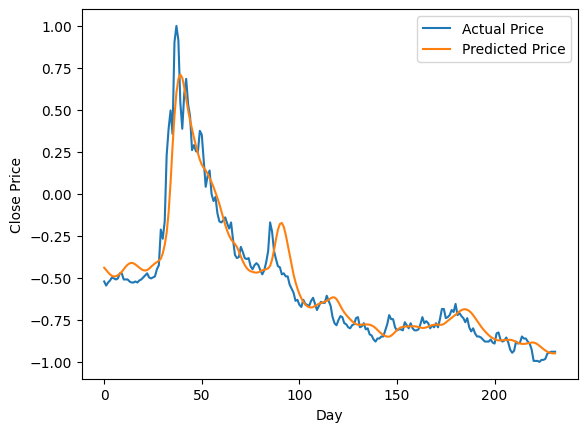

LSTM(
  (lstm): LSTM(1, 63, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=63, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.404
***************************************************
Epoch: 2

Val Loss: 0.392
***************************************************
Epoch: 3

Val Loss: 0.386
***************************************************
Epoch: 4

Val Loss: 0.369
***************************************************
Epoch: 5

Val Loss: 0.346
***************************************************
Epoch: 6

Val Loss: 0.330
***************************************************
Epoch: 7

Val Loss: 0.258
***************************************************
Epoch: 8

Val Loss: 0.166
***************************************************
Epoch: 9

Val Loss: 0.098
***************************************************
Epoch: 10

Val Loss: 0.057
***************************************************
Epoch: 11

Val Loss: 0.047
***************************************************
Epoch: 

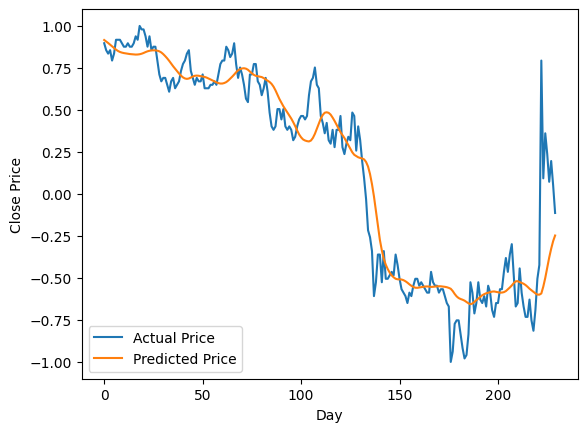

In [19]:
# Hyperparameters
lookback = 21  # Increased lookback window for capturing longer dependencies
hidden_size = 63  # Increased hidden size
num_stacked_layers = 3  # Stack multiple LSTM layers
dropout_rate = 0.3  # Dropout to prevent overfitting
learning_rate = 0.0001  # Lower learning rate for better convergence
batch_size = 16
num_epochs = 101
patience_threshold = 11  # Early stopping patience

# Processing the data for each tag
tag_list = ['Open', 'High', 'Low', 'Close']
for tag_name in tag_list:
    for file in files[:-1]:  # Exclude current year's data for training
        data = pd.read_csv(file)
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.rename(columns={tag_name: 'Price'})
        data = data[['Date', 'Price']]

        # Prepare shifted dataframe
        shifted_df = prepare_dataframe_for_lstm(data, lookback)
        shifted_df_as_np = shifted_df.to_numpy()

        # Scaling the data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

        X = shifted_df_as_np[:, 1:]
        y = shifted_df_as_np[:, 0]
        X = dc(np.flip(X, axis=1))

        X = X.reshape((-1, lookback, 1))  # Input reshape for LSTM
        y = y.reshape((-1, 1))

        X = torch.tensor(X).float()
        y = torch.tensor(y).float()

        train_dataset = TimeSeriesDataset(X, y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Model Initialization
        model = LSTM(1, hidden_size, num_stacked_layers, dropout_rate)
        model.to(device)
        print(model)

        # Loss, Optimizer, and Early Stopping Setup
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        
        best_val_loss = float('inf')
        patience_counter = 0

        # Training and validation loop with early stopping
        for epoch in range(num_epochs):
            train_one_epoch(train_loader, model, optimizer, loss_function, epoch)
            val_loss = validate_one_epoch(train_loader, model, loss_function)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model
                save_path = f'/workspaces/Futures-First/Prediction/LSTM/test/{tag_name}/'
                os.makedirs(save_path, exist_ok=True)
                torch.save(model.state_dict(), os.path.join(save_path, f'lstm_model_{file.split("/")[-1].split(".")[0]}.pt'))
            else:
                patience_counter += 1

            if patience_counter >= patience_threshold:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        # Predict and visualize results
        with torch.no_grad():
            predicted = model(X.to(device)).to('cpu').numpy()

        plt.plot(y, label='Actual Price')
        plt.plot(predicted, label='Predicted Price')
        plt.xlabel('Day')
        plt.ylabel(f'{tag_name} Price')
        plt.legend()
        plt.show()

In [20]:
df1 = pd.read_csv(files[-1])
last_row = df1[['Open', 'High', 'Low', 'Close']].iloc[-2:]

ohlc = {
    'Open': list(last_row['Open']),
    'High': last_row['High'].tolist(),
    'Low': last_row['Low'].tolist(),
    'Close': last_row['Close'].tolist()
}

print(ohlc)

{'Open': [-20.25, -20.5], 'High': [-19.75, -20.5], 'Low': [-20.75, -22.25], 'Close': [-20.5, -21.75]}


In [21]:
# Ensure the test code matches training setup
lookback = 21  # Updated to match the training lookback period
hidden_size = 63  # Updated to match training hidden size
num_stacked_layers = 3  # Updated to match training model depth
dropout_rate = 0.3  # Match dropout rate used in training

# Prepare data for LSTM
for tag_name in tag_list:
    def prepare_dataframe_for_lstm(df, n_steps):
        df = dc(df)
        df.set_index('Date', inplace=True)
        for i in range(1, n_steps+1):
            df[f'Price(t-{i})'] = df['Price'].shift(i)
        df.dropna(inplace=True)
        return df

    # Load and prepare the test data
    data = pd.read_csv(files[-1])  # Use the latest file for testing
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.rename(columns={tag_name: 'Price'})
    data = data[['Date', 'Price']]

    shifted_df = prepare_dataframe_for_lstm(data, lookback)

    shifted_df_as_np = shifted_df.to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    X = dc(np.flip(X, axis=1))

    X = X.reshape((-1, lookback, 1))
    y = y.reshape((-1, 1))

    X_test = torch.tensor(X).float()
    y_test = torch.tensor(y).float()

    # Load the trained model
    model_file = '/workspaces/Futures-First/Prediction/LSTM/test/'+tag_name+'/lstm_model_'+files[-2][-8:-4]+'.pt'
    model = LSTM(input_size=1, hidden_size=hidden_size, num_stacked_layers=num_stacked_layers, dropout_rate=dropout_rate).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    # Predict the test set
    with torch.no_grad():
        test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

    # Inverse transform the test predictions and actual values
    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = test_predictions
    dummies = scaler.inverse_transform(dummies)
    test_predictions = dc(dummies[:, 0])

    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = y_test.flatten()
    dummies = scaler.inverse_transform(dummies)
    new_y_test = dc(dummies[:, 0])

    # Predict future prices
    last_window = X_test[-1].cpu().numpy()

    future_predictions = []

    # Predict the next 10 days
    for _ in range(10):
        # Predict the next price
        pred = model(torch.tensor(last_window).unsqueeze(0).float().to(device)).detach().cpu().numpy().flatten()[0]
        
        # Scale back to original price
        dummies = np.zeros((1, lookback + 1))
        dummies[:, 0] = pred
        dummies = scaler.inverse_transform(dummies)
        
        pred_original = dummies[:, 0][0]
        future_predictions.append(pred_original)
        
        # Update the window for the next prediction
        last_window = np.roll(last_window, -1)
        last_window[-1, 0] = pred

    # Combine all predictions (past and future)
    all_predictions = np.concatenate((test_predictions, np.array(future_predictions)))

    # Plot the actual vs. predicted values
    fig = go.Figure()

    # Actual values
    fig.add_trace(go.Scatter(
        x=np.arange(len(new_y_test)),
        y=new_y_test,
        mode='lines',
        name='Actual Price'
    ))

    # Predicted values (past)
    fig.add_trace(go.Scatter(
        x=np.arange(len(test_predictions)),
        y=test_predictions,
        mode='lines',
        name='Predicted Price (Past)'
    ))

    # Predicted values (future)
    fig.add_trace(go.Scatter(
        x=np.arange(len(test_predictions), len(all_predictions)),
        y=future_predictions,
        mode='lines',
        name='Predicted Price (Future)',
        # line=dict(dash='dash')
    ))

    # Update plot layout
    fig.update_layout(
        title=f"Futures Price Prediction of {tag_name}",
        xaxis_title="Day",
        yaxis_title="Price",
        legend_title="Legend"
    )

    # Show the plot
    fig.show()

    # Save future predictions
    ohlc[tag_name].extend(future_predictions[:4])


/tmp/ipykernel_5459/2265731977.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_5459/2265731977.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_5459/2265731977.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_5459/2265731977.py:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [22]:
candle = go.Candlestick(
    x=['T-2_real','T-1_real','T-1','T','T+1'],  
    open=ohlc['Open'],
    high=ohlc['High'],
    low=ohlc['Low'],
    close=ohlc['Close']
)

# Create a figure and add the candlestick
fig = go.Figure(data=[candle])

# Update layout to show titles
fig.update_layout(title='Candlesticks for '+files[-1][-19:-9]+" Long", xaxis_title='Date', yaxis_title='Price')
# fig.update_layout(title='Candlesticks for '+files[-1][-15:-9], xaxis_title='Date', yaxis_title='Price')

# Show the figure
fig.show()